In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy import stats, signal
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [3]:
import io
import datetime
import urllib.request
import itertools
import warnings

# Seasonal Decomposition

## Trial Data

We use the well known [Mauna Loa Carbon Dioxide dataset][1]. Following function fetch the file from ftp:

[1]: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt

In [4]:
def to_dataframe(fname=None):
    """
    Read Moana Loa CO2 FWF Source File:
    """
    if fname is None:
        uri = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt'
        with urllib.request.urlopen(uri) as response:
            lines = response.read().decode().split("\n")
        with open("CO2_{:%Y%m%d}.txt".format(datetime.datetime.utcnow()), 'w') as file:
            file.write("\n".join(lines))
    else:
        with open(fname) as file:
            lines = map(str.strip, file.readlines())
    stream = io.StringIO("\n".join(filter(lambda x: not(x.startswith('#')), lines)))
    df = pd.read_fwf(
        stream,
        header=None, usecols=[0, 1, 2, 4, 5],
        names=['year', 'month', 'day', 'value', 'ndays'],
        parse_dates={'timestamp': ['year', 'month', 'day']},
        index_col='timestamp',
        na_values=[-999.99]
    )
    return df

In [5]:
df = to_dataframe('co2_weekly_mlo.txt').interpolate(mode='time')
df.head()

,value,ndays
timestamp,,
1974-05-19,333.34,6
1974-05-26,332.95,6
1974-06-02,332.32,5
1974-06-09,332.18,7
1974-06-16,332.37,7


Plotting data shows up the CO2 trend:

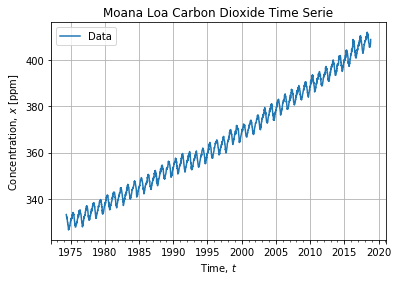

In [6]:
axe = df['value'].plot(label='Data')
axe.set_title('Moana Loa Carbon Dioxide Time Serie')
axe.set_xlabel('Time, $t$')
axe.set_ylabel('Concentration, $x$ $[\mathrm{ppm}]$')
axe.grid()
axe.legend()

## Seasonal Detrend

In [7]:
season = seasonal_decompose(df['value'], model='additive', freq=4*52)

In [8]:
smooth = signal.savgol_filter(df['value'].squeeze(), 4*52+1, 7)

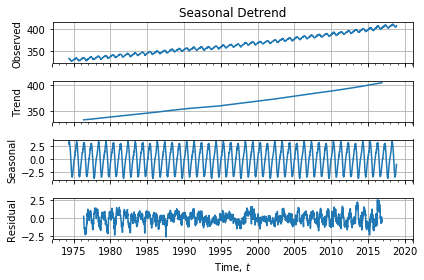

In [9]:
fig = season.plot()
axes = fig.get_axes()
axes[0].set_title("Seasonal Detrend")
axes[-1].set_xlabel("Time, $t$")
for axe in axes:
    axe.grid()
fig.tight_layout()

In [10]:
df['season'] = season.trend
df['smooth'] = smooth

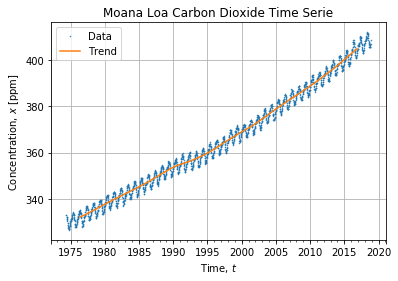

In [11]:
axe = df['value'].plot(label='Data', linestyle='none', marker='o', markersize=0.5)
df['season'].plot(ax=axe, label='Trend')
#df['smooth'].plot(ax=axe, label='Smooth Trend')
axe.set_title('Moana Loa Carbon Dioxide Time Serie')
axe.set_xlabel('Time, $t$')
axe.set_ylabel('Concentration, $x$ $[\mathrm{ppm}]$')
axe.grid()
axe.legend()

## Residual Analysis

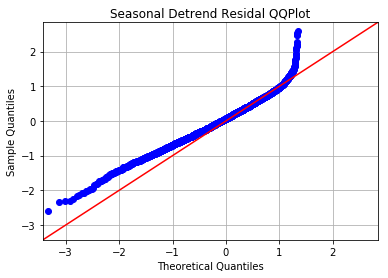

In [12]:
fig = sm.qqplot(season.resid, stats.norm, fit=False, line='45')
axe = fig.get_axes()[0]
axe.set_title("Seasonal Detrend Residal QQPlot")
axe.grid()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


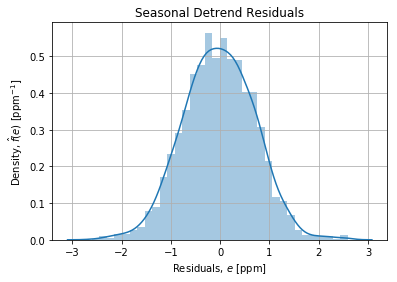

In [13]:
axe = sns.distplot(season.resid.dropna(), kde=True)
axe.set_title("Seasonal Detrend Residuals")
axe.set_xlabel('Residuals, $e$ $[\mathrm{ppm}]$')
axe.set_ylabel('Density, $\hat{f}(e)$ $[\mathrm{ppm^{-1}}]$')
#axe.legend(['Bins', 'KDE'])
axe.grid()

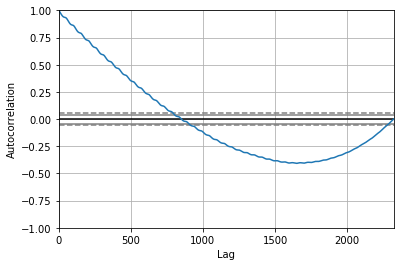

In [14]:
pd.plotting.autocorrelation_plot(df['value'])

## Forecast

In [15]:
x = df.loc[:,"value"].resample('MS').agg(['mean', 'std', 'count'])
x.head()

,mean,std,count
timestamp,,,
1974-05-01,333.1450,0.275772,2
1974-06-01,332.0280,0.366838,5
1974-07-01,330.7125,0.678988,4
1974-08-01,329.0725,0.620880,4
1974-09-01,327.3240,0.517958,5


In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
spdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [17]:
def gen_AIC():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for param in pdq:
            for pseasonal in spdq:
                try:
                    model = sm.tsa.statespace.SARIMAX(
                        x['mean'],
                        order=param,
                        seasonal_order=pseasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    results = model.fit()
                    yield (param, pseasonal, results.aic)
                except:
                    raise
                    continue

In [18]:
p = pd.DataFrame(gen_AIC(), columns=['param', 'pseasonal', 'AIC'])

In [19]:
p.head()

,param,pseasonal,AIC
0,"(0, 0, 0)","(0, 0, 0, 12)",7822.012895
1,"(0, 0, 0)","(0, 0, 1, 12)",7660.714105
2,"(0, 0, 0)","(0, 1, 0, 12)",2161.107652
3,"(0, 0, 0)","(0, 1, 1, 12)",1783.228088
4,"(0, 0, 0)","(1, 0, 0, 12)",1014.099243


In [20]:
pset = p.iloc[p['AIC'].idxmin(),:]
pset

param            (1, 0, 1)
pseasonal    (0, 1, 1, 12)
AIC                295.979
Name: 43, dtype: object

In [21]:
model = sm.tsa.statespace.SARIMAX(
    x['mean'],
    order=pset['param'],
    seasonal_order=pset['pseasonal'],
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               mean   No. Observations:                  535
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -143.989
Date:                            Sun, 25 Nov 2018   AIC                            295.979
Time:                                    13:16:22   BIC                            312.908
Sample:                                05-01-1974   HQIC                           302.617
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0012      0.001   1814.145      0.000       1.000       1.002
ma.L1         -0.4622      0.034    -13.461      0.000      -0.530      -0.395
ma.S.L12      -0.8870      0.024    -37.322      0.000      -0.934      -0.840
sigma2         0.1008      0.005     19.213      0.000       0.090       0.111
===================================================================================
Ljung-Box (Q):                       36.84   Jarque-Bera (JB):                18.27
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

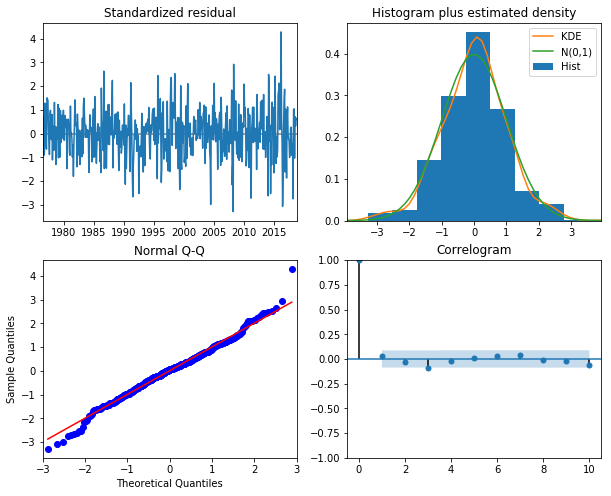

In [23]:
fig = results.plot_diagnostics(figsize=(10, 8))

In [80]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), stop=pd.to_datetime('2025-01-01'), dynamic=False)
conf = pred.conf_int(alpha=0.001)

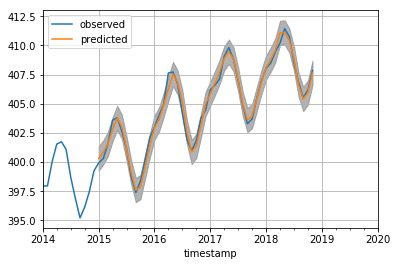

In [81]:
axe = x.loc['2014':,'mean'].plot(label='observed')
pred.predicted_mean.plot(ax=axe, label='predicted')#, linestyle='none', marker='+')
axe.fill_between(conf.index, conf.iloc[:,0], conf.iloc[:,1], color='gray', alpha=0.6)
#results.forecast(12*5).plot(ax=axe, label='forecasted')
axe.set_xlim(['2014','2020'])
axe.grid()
axe.legend()

In [36]:
type(results.forecast(12*5, alpha=0.1))

pandas.core.series.Series

In [37]:
type(results)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

In [52]:
np.abs(results.maroots)

array([1.01004355, 1.01004355, 1.01004355, 1.01004355, 1.01004355,
       1.01004355, 1.01004355, 1.01004355, 1.01004355, 1.01004355,
       1.01004355, 1.01004355, 2.16337699])